In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
import math as m
import pandas as pd
import glob
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

In [2]:
# FUNCTIONS

def read_file(directory, filename, separator, rowstoskip, head='infer'):
    """
    Reads an external file and outputs it as a Pandas Dataframe
    Input: Directory, Filename (Strings)
    Output: Pandas Dataframe
    """
    path=os.path.join(directory, filename)
    dataset = pd.read_csv(path, header = head, sep=separator, skiprows=rowstoskip)
    
    return dataset


def planck(wavenumber, temperature): # T in Kelvin, wavenumber in cm^-1
    """
    Calculates spectral radiance of a black body at some wavenumber and temperature
    Input: wavenumber (units: cm^{-1}), and temperature T (units: Kelvin) - (Integers or Floats)
    Output: spectral radiance (units: W m^{-2} sr^{-1} cm^{-1}) - (Float)
    """
    h = 6.626e-34
    c = 3.0e+8
    k = 1.381e-23

    planck_a = 2*h*(c**2)
    planck_e = h*c/k
    radiance = 100*planck_a*((wavenumber*100)**3)/(np.exp(planck_e*(wavenumber*100)/temperature)-1)

    return radiance


def read_raw_spectra(directory, filename):
    """
    Reads spectrum file and calculates the average of the 4 spectra
    Input: Directory, Filename (Strings)
    Output: average_spectrum (NumPy Array)
    """
    file_data = read_file(directory, filename, separator='  ', rowstoskip=5, head=None)
    spectrum1 = file_data[1].values
    spectrum2 = file_data[2].values
    spectrum3 = file_data[3].values
    spectrum4 = file_data[4].values
    average_spectrum = 0.25*(np.sum([spectrum1, spectrum2, spectrum3, spectrum4], axis=0))
    
    return average_spectrum


def file_path_list(path_raw):
    """
    creates list of file paths starting with 'IC_raw_spectra' from 'path_raw' directory
    input: raw path
    output: list of file names
    """
    measurements = len(glob.glob(path_raw + '/'+ file_name + '*'))
    m_numbers = list(range(measurements)) #list of file name endings (integers)

    for i in m_numbers:
        #checks that files have associated temperature measurements, and removes the files if not
        temp_check = read_file(path_raw, file_name + str(i) + '.txt', separator='  ', rowstoskip=None, head=None).iloc[1,0]
        if temp_check == 0.0:
            m_numbers.pop(i)

    files = [file_name + str(num) + '.txt' for num in m_numbers] #final list of strings of file names, in order
    
    return files
    
    
def spectrum_times(files, path_raw):
    """
    Input: files returned from file_path_list function
    Output: array of spectra times in secs form midnight
    """
    # Create a Pandas DataFrame of dimensions (len(files)x4), containing spectra times as HH:MM:SS.millisec strings
    times_df = pd.DataFrame(index=np.arange(0, len(files)), columns = ('time1','time2','time3','time4'))
    read_times = np.array([]) #array of dimensions (len(files)x1). Each element is a string of 4 times

    for i in np.arange(0, len(files)):
        #read times from each file and return read_times array. Replace row of times_df with the strings of time (split times by ' ')
        read_times = np.append(read_times, read_file(path_raw, files[i], separator = ',', rowstoskip=None, head=None).iloc[0].values)
        times_df.loc[i] = read_times[i].split()

    spectrum_times = np.array([]) #array of dimensions (273*4 x 1), containing all spectra times in seconds from midnight format

    for t in times_df.values.flatten():
        #times_df converted to 'spectrum_times' array, with new format (seconds from midnight)
        time = datetime.datetime.strptime(t, '%H:%M:%S.%f')
        spectrum_times = np.append(spectrum_times, time.microsecond/1000000 + time.second + time.minute*60 + time.hour*3600)
        
    return spectrum_times    


def log_file(path_raw, full_log, spectrum_times):
    """
    Create DataFrame of the event log giving time, room temperature, cold blackbody (CBB) and hot blackbody (HBB) temperatures, and orientation (facing HBB or CBB)

    """
    raw_file = read_file(path_raw, full_log, separator=',', rowstoskip=None, head=None) #read log file
    raw_file1 = raw_file[[1,6,8,9,10,11]].loc[raw_file[11] != 0] #select useful data outlined above; removing rows where 'Orientation'=0

    log_file = raw_file1.reset_index(drop=True) #reset index to go from 0
    log_file.columns = ['Real Time', 'room_temp', 'hbb_temp','cbb_temp','Time','Orientation'] #all the column names
    log_file['hc'] = np.nan #add empty 'hc' column

    log_file.loc[log_file['Orientation'] == 270, 'hc'] = 'h' #if Orientation=270, 'h' (facing HBB)
    log_file.loc[log_file['Orientation'] == 225, 'hc'] = 'c' #if Orientation=225, 'c' (facing CBB)


    times = spectrum_times[0::4] #start times of each 4 spectra in one file
    log_length = log_file.shape[0] #length of the log_file

    for i in np.arange(0,len(times)):
        #add (len(files)) empty rows log_file DataFrame, and insert 'times' into the new rows with empty 'Time' columns, leaving 'NaN' in all other columns
        log_file.loc[log_length+i]= np.nan
        log_file.loc[log_length+i, 'Time'] = times[i]

    log_file = log_file.sort_values('Time') #sort log_file DataFrame into order based on 'Time' column (inserts the spectra times in order)
    log_file = log_file.reset_index(drop=True)
    
    return log_file, times


def spectra(log_file, path_raw, files, times):
    """
    Create DataFrame with start time of measured spectra, their h/c status, average temperature, and temperature standard deviation
    Also return array of wavenums and list containing all spectra

    """
    hc_list = [] #list of 'h' or 'c' values associated with the spectra
    temps_avg = [] #list of average temperatures over each spectrum
    temps_std = [] #list of temperature standard deviations over each spectrum

    d = log_file.index[-1] #last index of log_file
    while log_file.at[d, 'hc'] == 'c' or log_file.at[d, 'hc'] == 'h':
        #search through rows from end to beginning in log_file to search for rows without an associated 'hc' value
        d -=1

    for i in range(d-1):
        #assign 'h' or 'c' values for the hc column of log_file for the spectra (which currently only have a 'Time'), based on the value of the next h/c in the list
        value = log_file.at[i, 'hc']
        if value != 'c' and value != 'h': #value in 'hc' column neither h/c (locate spectra)
            hot_or_cold = log_file.iloc[i+1]['hc']
            hc_list.append(hot_or_cold) # the spectra are assigned the h_c value of the following time
            temp_list = []
            a=2
            if hot_or_cold == 'h':
                #if spectrum is hot, find its avg. temp. using temperatures in the 'hbb_temp' column of the next rows until the start of the next spectrum
                num = log_file.iloc[i+1]['hbb_temp']
                while m.isnan(num) == False:
                    temp_list.append(num)
                    num = log_file.iloc[i+a]['hbb_temp']
                    a += 1
                temps_avg.append(np.average(temp_list))
                temps_std.append(np.std(temp_list)) #standard deviation of temperatures used to calculate temperature of the spectrum
            elif hot_or_cold == 'c':
                #if spectrum is cold, use same procedure but with temperatures from the 'cbb_temp' column
                num = log_file.iloc[i+1]['cbb_temp']
                while m.isnan(num) == False:
                    temp_list.append(num)
                    num = log_file.iloc[i+a]['cbb_temp']
                    a += 1
                temps_avg.append(np.average(temp_list))
                temps_std.append(np.std(temp_list))


    final_frame_4 = pd.DataFrame(
        {'Time': times[:-1],
         'h_or_c': hc_list,
         'temp_avg': temps_avg,
         'temp_std': temps_std
        })
    
    wavenums = read_file(path_raw, files[0], separator='  ', rowstoskip=5, head=None)[0].values #NumPy array of the spectral range (units: cm^{-1})
    all_spectra = [] #spectra from all the files

    for f in files:
        all_spectra.append(read_raw_spectra(path_raw, f))
    
    return final_frame_4, wavenums, all_spectra


def response_fn(all_spectra, spectrum_number, final_frame_4, wavenums):
    """
    Returns the response function at some time and wavenumber
    """
    (a,b) = (all_spectra[spectrum_number], all_spectra[spectrum_number + 1])
    if a[1000] < b[1000]:
        V_c = a
        V_h = b
    else:
        V_c = b
        V_h = a
        
    V_diff = np.array(V_h)-np.array(V_c)
    
    (e,f) = (final_frame_4.at[spectrum_number,'temp_avg'], final_frame_4.at[spectrum_number+1,'temp_avg'])
   # +1 and +2 are ad hoc to make the code work!!!!
    if e<f:
        temp_average_c = e
        temp_average_h = f
    else:
        temp_average_c = f
        temp_average_h = e

    radiances_avg_h = [planck(wn, temp_average_h+273.15) for wn in wavenums]
    radiances_avg_c = [planck(wn, temp_average_c+273.15) for wn in wavenums]
    rad_diff = np.array(radiances_avg_h) - np.array(radiances_avg_c)
    
    def division(raw_val,planck_val):
        if planck_val == 0:
            div = 0
        else:
            div = raw_val/planck_val
        return div
    
    division_vec = np.vectorize(division)
    ratio = division_vec(V_diff, rad_diff)
    
    return(ratio)


def finding_std_dev(n, final_frame_4, wavenums, all_spectra):
    """
    Find fractional std dev of response function based on standard dev of temperatures - may need to realign lengths of "all_spectra" and "final_frame_4" so they align

    """
    (a,b,c,d) = (final_frame_4.at[n,'temp_avg'], final_frame_4.at[n+1,'temp_avg'], final_frame_4.at[n,'temp_std'], final_frame_4.at[n+1,'temp_std'])
    if a<b:
        T_c = a
        T_h = b
        std_dev_Tc = c
        std_dev_Th = d
    else:
        T_c = b
        T_h = a
        std_dev_Tc = d
        std_dev_Th = c

    L_h = [planck(wn, T_h+273.15) for wn in wavenums] #radiance of HBB @ spec_num or spec_num+1
    L_h_plus = [planck(wn, T_h+273.15+std_dev_Th) for wn in wavenums] #spectrum of radiance + 1 std dev of radiance of HBB
    L_h_std = np.array(L_h_plus) - np.array(L_h) #spectrum of radiance std dev of HBB
    
    L_c = [planck(wn, T_c+273.15) for wn in wavenums] #radiance curve of CBB @ spec_num or spec_num+1
    L_c_plus = [planck(wn, T_c+273.15+std_dev_Tc) for wn in wavenums] #spectrum of radiance + 1 std dev of radiance of CBB
    L_c_std = np.array(L_c_plus) - np.array(L_c)
    
    L_diff = np.array(L_h) - np.array(L_c)
    term2 = 1/(L_diff**2)                    
    term3 = np.sqrt(L_h_std**2 + L_c_std**2) 
    
    (e,f) = (all_spectra[n], all_spectra[n+1])
    if e[1000] < f[1000]:
        V_c = e
        V_h = f
    else:
        V_c = f
        V_h = e
    V_diff = np.array(V_h)-np.array(V_c) #term1
    
    std_dev_resp_fn = V_diff * term2 * term3
    resp_fn = [i/j for (i,j) in zip(V_diff, L_diff)]
    perc_std_dev = [i*100/j for (i,j) in zip(std_dev_resp_fn, resp_fn)]
    
    return(perc_std_dev)


def resp_from_end(wn, wavenums, all_resp_functions): #there are two responses per wn
    """
    Finds standard deviation of response function for a certain wavenumber starting from the last time
    """
    wavenumber = min(wave for wave in wavenums if wave > wn) #find closest wavenumber to the one called by the user
    index = list(wavenums).index(wavenumber)
    wn_responses = [all_resp_functions[a][index] for a in range(len(all_resp_functions))]
    
    #start taking the last 10 values and expand
    stds_from_back = [np.std(wn_responses[-10-i:-1]) for i in range(0, len(wn_responses)-10)]
    avgs_from_back = [np.average(wn_responses[-10-i:-1]) for i in range(0, len(wn_responses)-10)]
    fractional_stds_from_back = [a/b*100 for (a,b) in zip(stds_from_back,avgs_from_back)] #in percent
    
    return fractional_stds_from_back, wavenumber


def all_stds_from_back(wavenums, all_resp_functions, times):
    """
    Calculate all stds from back, and create arrays for x and y coordinates of the 3D plot
    """
    
    all_stds_from_back = []

    for wn in wavenums[:1890]: #this is up to wn of 1250
        fractional_stds_from_back, wavenumber = resp_from_end(wn, wavenums, all_resp_functions)
        all_stds_from_back.append(np.array(fractional_stds_from_back))

    flat_stds = [item for sublist in all_stds_from_back for item in sublist]

    wavenums_plot = []

    for wn in wavenums[:1890]:
        wavenums_plot.append([wn] * (len(times[1:-2:2])-10))
    flat_wns = [item for sublist in wavenums_plot for item in sublist]

    times_plot = list(times[1:-2:2])[::-1][:-10]
    flat_times = [item for sublist in [times_plot]*len(wavenums[:1890]) for item in sublist]

    return flat_times, flat_wns, flat_stds

In [40]:
# GRAPHING FUNCTIONS

def plot_resp(material, all_resp_functions, wavenums, times, log_file):
    """
    Plots response function as function of wavenumber and time, with hot and cold BB temperatures on the side
    """
    grid = plt.GridSpec(1, 7, wspace=0)

    fig = plt.figure(figsize=(15,9))

    ax1 = fig.add_subplot(grid[0,:5])
    p = ax1.pcolor(wavenums, times[:-2:2], all_resp_functions)
    plt.title('Response function '+ str(material)+' Volts/($W m^{-2} sr^{-1} (cm^{-1})^{-1}$)')
    plt.xlabel('Wavenumber $cm^{-1}$')
    plt.ylabel('Time (s)')
    cbaxes = fig.add_axes([0, 0.1, 0.01, .8]) 
    cb = fig.colorbar(p, cax = cbaxes)

    ax2 = fig.add_subplot(grid[0,5:6], sharey = ax1)
    ax2.plot(log_file['cbb_temp'], log_file['Time'], 'b')
    plt.grid()
    plt.xlabel('Cold BB temp ($\degree$C)')
    plt.tick_params(
        axis='y',
        which='both',
        left=False,
        right=False,        
        labelleft=False)

    ax3 = fig.add_subplot(grid[0,6:7], sharey = ax1)
    ax3.plot(log_file['hbb_temp'], log_file['Time'], 'r')
    plt.grid()
    plt.xlabel('Hot BB temp ($\degree$C)')
    plt.tick_params(
        axis='y',
        which='both',
        left=False,
        right=False,        
        labelleft=False)

    plt.show()
    
    
def plot_resp_diff(material, all_resp_functions, wavenums, times, log_file):
    """
    Plots response function difference compared to last response as function of wavenumber and time, with hot and cold BB temperatures on the side
    """
    diff_resp_functions = [i - all_resp_functions[-1] for i in np.array(all_resp_functions)]
    
    grid = plt.GridSpec(1, 7, wspace=0)

    fig = plt.figure(figsize=(15,9))

    ax1 = fig.add_subplot(grid[0,:5])
    p = ax1.pcolor(wavenums, times[:-2:2], diff_resp_functions)
    plt.title('Response function difference compared to last one Volts/($W m^{-2} sr^{-1} (cm^{-1})^{-1}$) for '+str(material))
    plt.xlabel('Wavenumber $cm^{-1}$')
    plt.ylabel('Time (s)')
    cbaxes = fig.add_axes([0, 0.1, 0.01, .8]) 
    cb = fig.colorbar(p, cax = cbaxes)

    ax2 = fig.add_subplot(grid[0,5:6], sharey = ax1)
    ax2.plot(log_file['cbb_temp'], log_file['Time'], 'b')
    plt.grid()
    plt.xlabel('Cold BB temp ($\degree$C)')
    plt.tick_params(
        axis='y',
        which='both',
        left=False,
        right=False,        
        labelleft=False)

    ax3 = fig.add_subplot(grid[0,6:7], sharey = ax1)
    ax3.plot(log_file['hbb_temp'], log_file['Time'], 'r')
    plt.grid()
    plt.xlabel('Hot BB temp ($\degree$C)')
    plt.tick_params(
        axis='y',
        which='both',
        left=False,
        right=False,        
        labelleft=False)

    plt.show()
    
    
def plot_resp_wn(material, n, wavenums, all_resp_functions):
    """
    Plots the nth response function in time
    """
    fig = plt.figure(figsize=(14,9))
    plt.scatter(wavenums, all_resp_functions[n], s=2)
    plt.title('Response function with '+str(material)+' window', fontsize=24) #  for spectrum {}'.format(n)
    plt.xlabel('Wavenumber $cm^{-1}$', fontsize=20)
    plt.ylabel('Response Volts/($W m^{-2} sr^{-1} (cm^{-1})^{-1}$)', fontsize=20)
    plt.tick_params(labelsize=20, labelcolor='black')
    plt.grid()
    #fig.savefig('Graphs/Sample_resp_function_polypropylene.png', dpi=600)
    plt.show()   
    
    
def plot_resp_time(material, n, all_resp_functions, times, wavenums):
    """
    Plots the nth response function in wavenumbers
    """
    plt.scatter(times[1:-2:2], [i[n] for i in all_resp_functions], s=2)
    plt.title('Response function for wavenumber ' + str(wavenums[n]) + ' $cm^{-1}$ for ' + str(material))
    plt.xlabel('Time')
    plt.ylabel('Response (Volts/($W m^{-2} sr^{-1} (cm^{-1})^{-1}$))')
    plt.show()


def plot_resp_std(material, wavenums, times, all_stand_devs, log_file):
    """
    Plot fractional std dev of response function based on standard dev of temperatures

    """
    
    grid = plt.GridSpec(1, 7, wspace=0)

    fig = plt.figure(figsize=(15,9))

    ax1 = fig.add_subplot(grid[0,:5])
    q = ax1.pcolor(wavenums, times[1::2], all_stand_devs)
    plt.title('Response function percentage standard deviation (%) for ' + str(material))
    plt.xlabel('Wavenumber $cm^{-1}$')
    plt.ylabel('Time (s)')
    cbaxes = fig.add_axes([0, 0.1, 0.01, .8]) 
    cb = fig.colorbar(q, cax = cbaxes)

    ax2 = fig.add_subplot(grid[0,5:6], sharey = ax1)
    ax2.plot(log_file['cbb_temp'], log_file['Time'], 'b')
    plt.grid()
    plt.xlabel('Cold BB temp ($\degree$C)')
    plt.tick_params(
        axis='y',
        which='both',
        left=False,
        right=False,        
        labelleft=False)

    ax3 = fig.add_subplot(grid[0,6:7], sharey = ax1)
    ax3.plot(log_file['hbb_temp'], log_file['Time'], 'r')
    plt.grid()
    plt.xlabel('Hot BB temp ($\degree$C)')
    plt.tick_params(
        axis='y',
        which='both',
        left=False,
        right=False,        
        labelleft=False)

    plt.show()
    
    
def plot_stds_from_back(wavenums, all_resp_functions, times, wns=[]):
    """
    Plot stand devs from back for some wavenumbers
    Input: array of wavenumbers 'wns' to plot
    """
    fig = plt.figure(figsize=(16, 8))
    #plt.title('Percent standard deviation of response function starting from the end', fontsize=26)
    plt.xlabel('Time (sec from midnight)', fontsize=30)
    plt.ylabel('Standard deviation (%)', fontsize=30)
    legend_wns = []
    
    for wn in wns:
        fractional_stds_from_back, wavenumber = resp_from_end(wn, wavenums, all_resp_functions)
        legend_wns.append(int(wavenumber))
        plt.plot(times[1:-104:2], fractional_stds_from_back[:-85:-1], linewidth=4)
        
    legend = plt.legend(legend_wns, title='Wavenumber ($cm^{-1}$)', fontsize=30, loc='upper center', ncol=2)
    plt.setp(legend.get_title(), fontsize = 30)
    plt.tick_params(labelsize=28, labelcolor='black')
    plt.grid()
    fig.savefig('Graphs/Percentage_rep_function_std_from_end_all.png', dpi=600)
    plt.show()    
    
    
def plot_percentage_stds_from_back(flat_times, flat_wns, flat_stds, material, azimuth=None, elevation=None):
    """
    Make 3D plot of all resp functions from back
    """
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(flat_times, flat_wns, flat_stds, s=1, cmap='inferno')
    ax.view_init(azim=azimuth, elev=elevation)
    ax.set_title('Percentage standard deviation of response function from back for '+str(material))
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Wavenumber $cm^{-1}$')
    ax.set_zlabel('Percentage standard deviation (%)')
    plt.show()    

In [4]:
# VARIABLES
file_name = 'IC_raw_spectra_'

"""Polypropylene"""
# path_raw_poly = 'H:/MSci Project/polypropylene' #Rachel's path containing all raw spectra
path_raw_poly = '/Users/micol/Documents/Imperial/Year4/Master_Project/polypropylene' #Micol's path containing all raw spectra

full_log_poly = 'poly_window_test1-20181218110622.log' #contains temperature and status of h/c BB target

"""After Realignment"""
#path_raw_znse = 'D:/2018_11' #Rachel's path containing all raw spectra
path_raw_znse = '/Users/micol/Documents/Imperial/Year4/Master_Project/Measurements_after_realignment' #Micol's path containing all raw spectra

full_log_znse = '2018-11-28-20181128102247.log'

In [5]:
# CODE

#Poly
files_p = file_path_list(path_raw_poly)
spectrum_times_p = spectrum_times(files_p, path_raw_poly)
log_file_p, times_p = log_file(path_raw_poly, full_log_poly, spectrum_times_p)
final_frame_4_p, wavenums_p, all_spectra_p = spectra(log_file_p, path_raw_poly, files_p, times_p)
indices_p = np.arange(1, len(all_spectra_p)-2, 2)   #array of every other (odd) index, starting at n=1, cold
all_resp_functions_p = [response_fn(all_spectra_p, i, final_frame_4_p, wavenums_p) for i in indices_p]  #list of arrays of response functions available to plot
flat_times_p, flat_wns_p, flat_stds_p = all_stds_from_back(wavenums_p, all_resp_functions_p, times_p)

#ZnSe: after realignment, whole data set
files_zn = file_path_list(path_raw_znse)
spectrum_times_zn = spectrum_times(files_zn, path_raw_znse)
log_file_zn, times_zn = log_file(path_raw_znse, full_log_znse, spectrum_times_zn)
final_frame_4_zn, wavenums_zn, all_spectra_zn = spectra(log_file_zn, path_raw_znse, files_zn, times_zn)
indices_zn = np.arange(1, len(all_spectra_zn)-2, 2)   #array of every other (odd) index, starting at n=1, cold
all_resp_functions_zn = [response_fn(all_spectra_zn, i, final_frame_4_zn, wavenums_zn) for i in indices_zn]  #list of arrays of response functions available to plot
flat_times_zn, flat_wns_zn, flat_stds_zn = all_stds_from_back(wavenums_zn, all_resp_functions_zn, times_zn)

/Users/micol/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


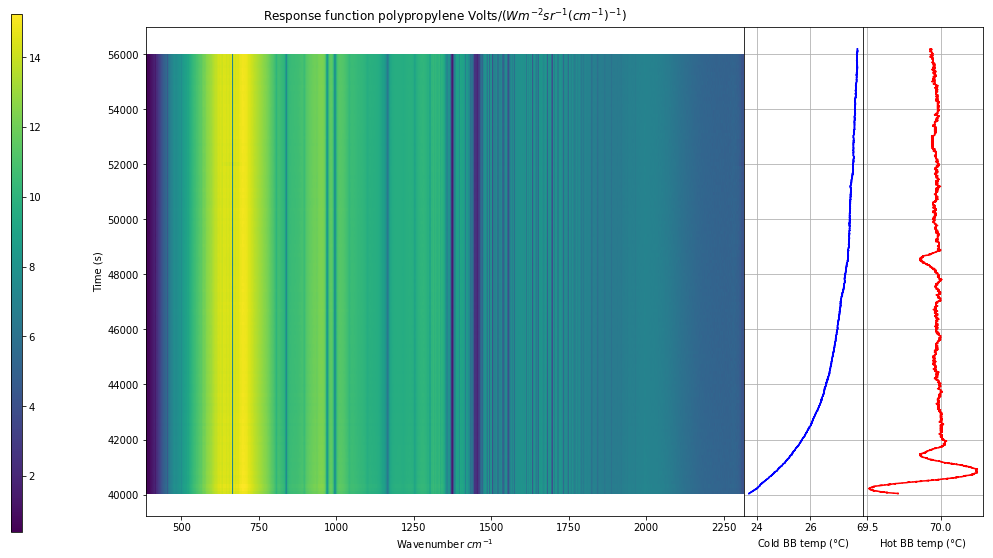

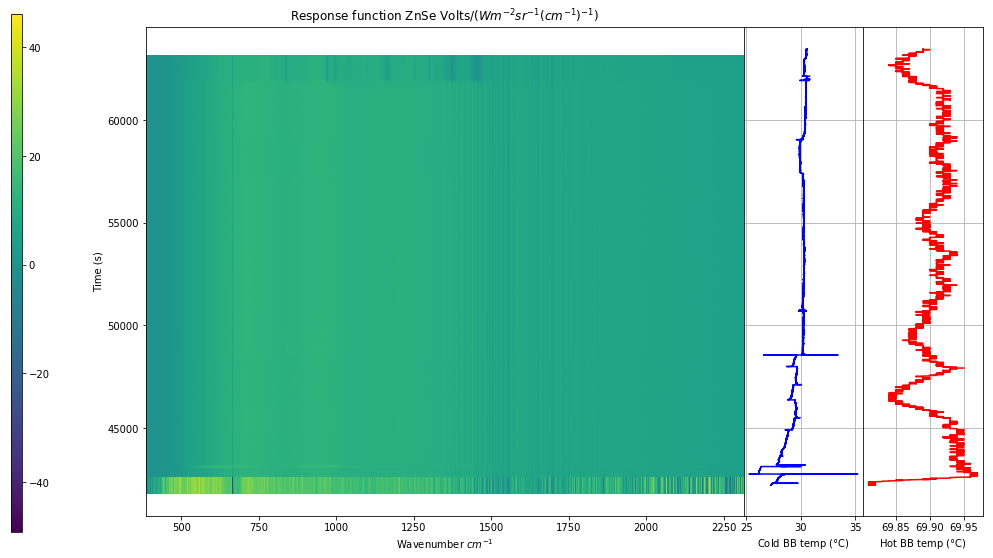

In [6]:
plot_resp('polypropylene', all_resp_functions_p, wavenums_p, times_p, log_file_p)
plot_resp('ZnSe', all_resp_functions_zn, wavenums_zn, times_zn, log_file_zn)

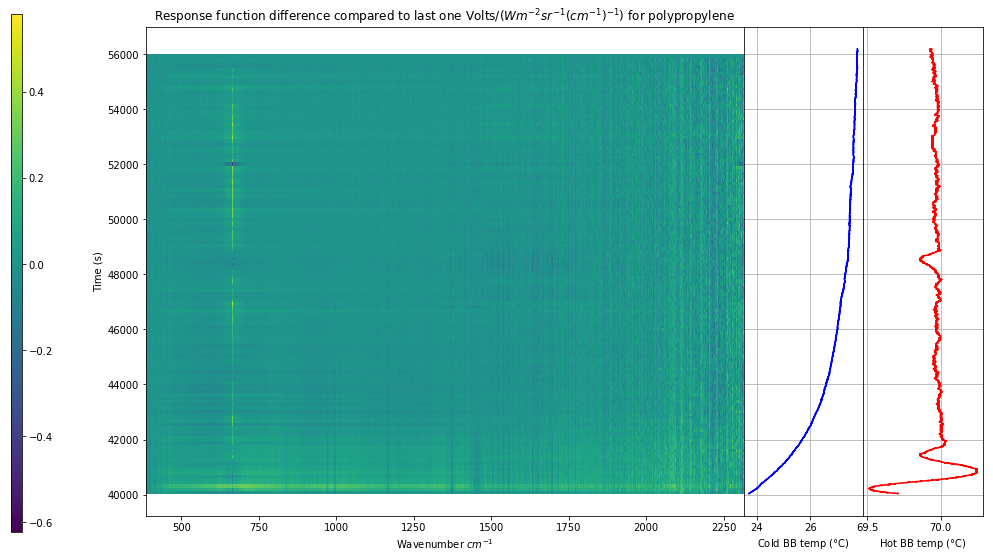

In [7]:
plot_resp_diff('polypropylene', all_resp_functions_p, wavenums_p, times_p, log_file_p)

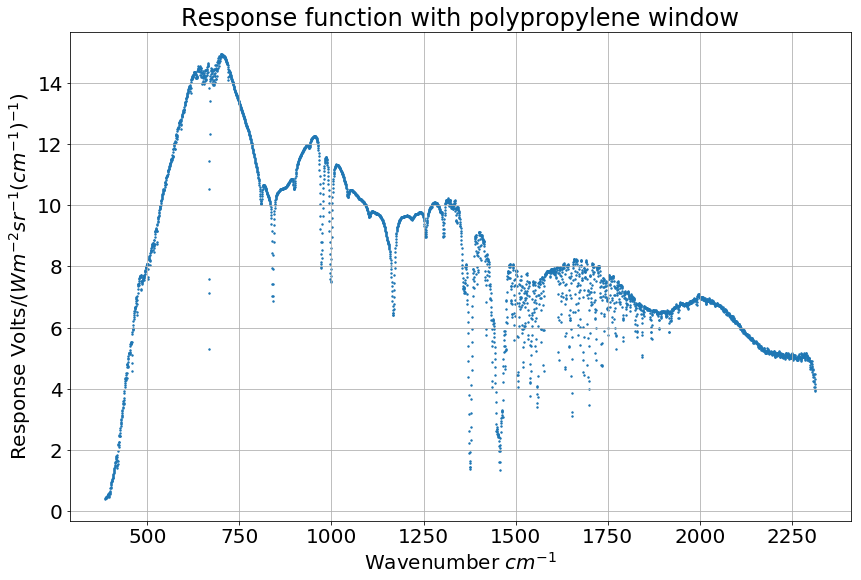

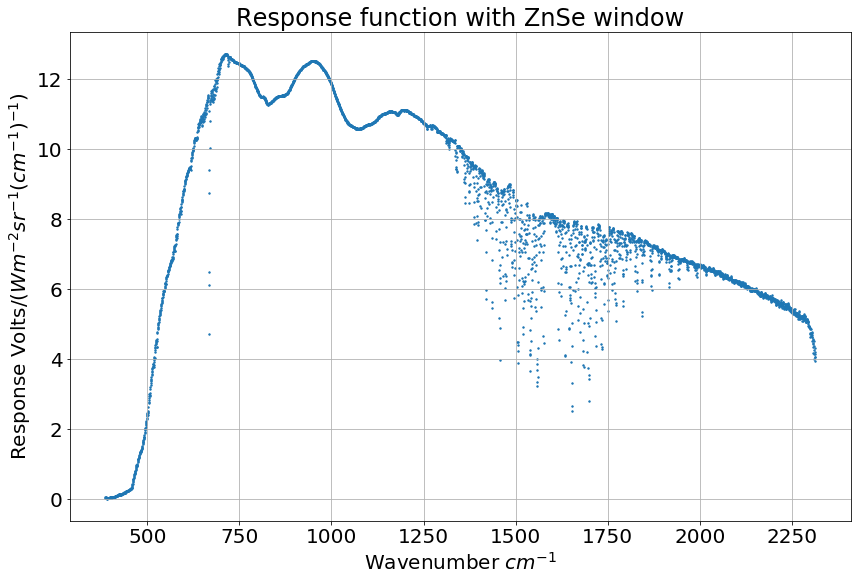

In [8]:
plot_resp_wn('polypropylene', len(all_resp_functions_p)-1, wavenums_p, all_resp_functions_p)
plot_resp_wn('ZnSe', len(all_resp_functions_zn)-50, wavenums_zn, all_resp_functions_zn)

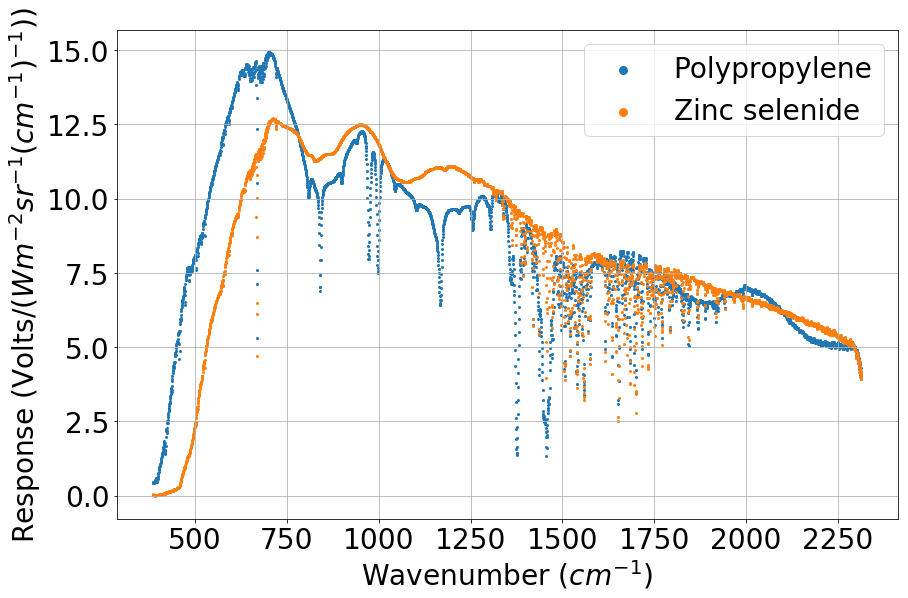

In [38]:
fig = plt.figure(figsize=(14,9))
plt.scatter(wavenums_p, all_resp_functions_p[len(all_resp_functions_p)-1], s=4)
plt.scatter(wavenums_zn, all_resp_functions_zn[len(all_resp_functions_zn)-50], s=4)
#plt.title('Response function for Poly and ZnSe windows', fontsize=24) #  for spectrum {}'.format(n)
plt.xlabel('Wavenumber ($cm^{-1}$)', fontsize=28)
plt.ylabel('Response (Volts/($W m^{-2} sr^{-1} (cm^{-1})^{-1}$))', fontsize=28)
plt.tick_params(labelsize=28, labelcolor='black')
plt.legend(['Polypropylene', 'Zinc selenide'], fontsize = 28, markerscale=4)
plt.grid()
fig.savefig('Graphs/Sample_resp_function_poly_zinc.png', dpi=600)
plt.show()   

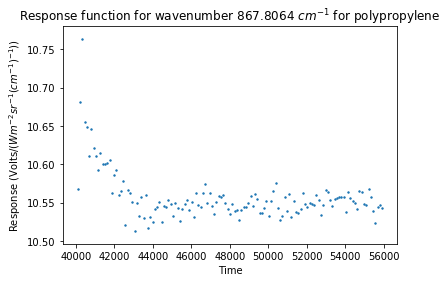

In [10]:
plot_resp_time('polypropylene', 1000, all_resp_functions_p, times_p, wavenums_p)

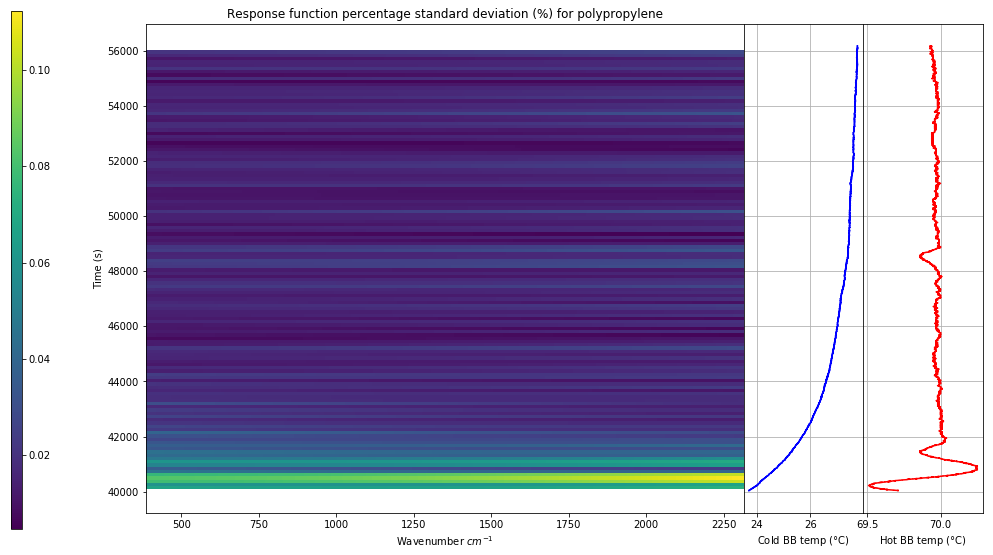

/Users/micol/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in double_scalars


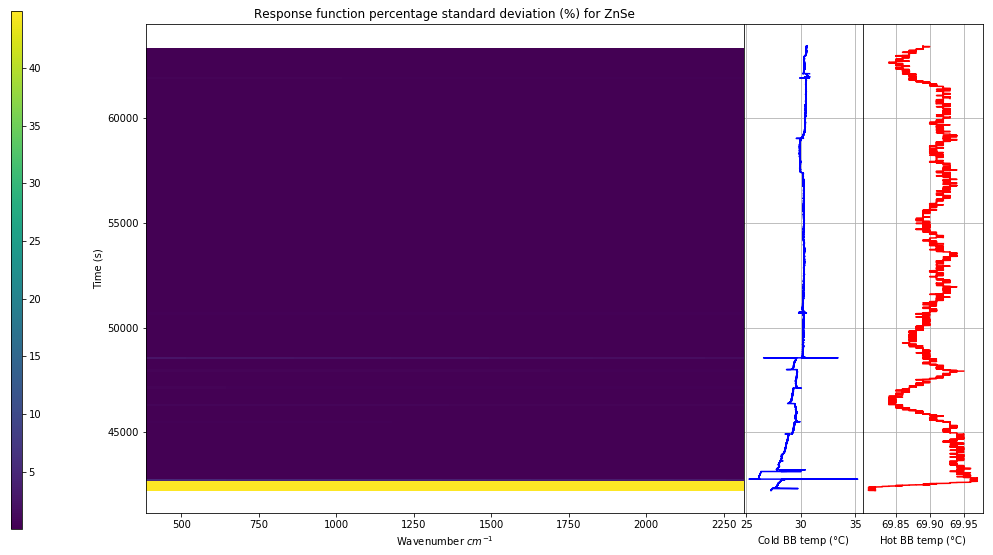

In [11]:
all_stand_devs_p = [finding_std_dev(n, final_frame_4_p, wavenums_p, all_spectra_p) for n in np.arange(1,len(times_p)-2, 2)]
plot_resp_std('polypropylene', wavenums_p, times_p, all_stand_devs_p, log_file_p)

all_stand_devs_zn = [finding_std_dev(n, final_frame_4_zn, wavenums_zn, all_spectra_zn) for n in np.arange(1,len(times_zn)-2, 2)]
plot_resp_std('ZnSe', wavenums_zn, times_zn, all_stand_devs_zn, log_file_zn)

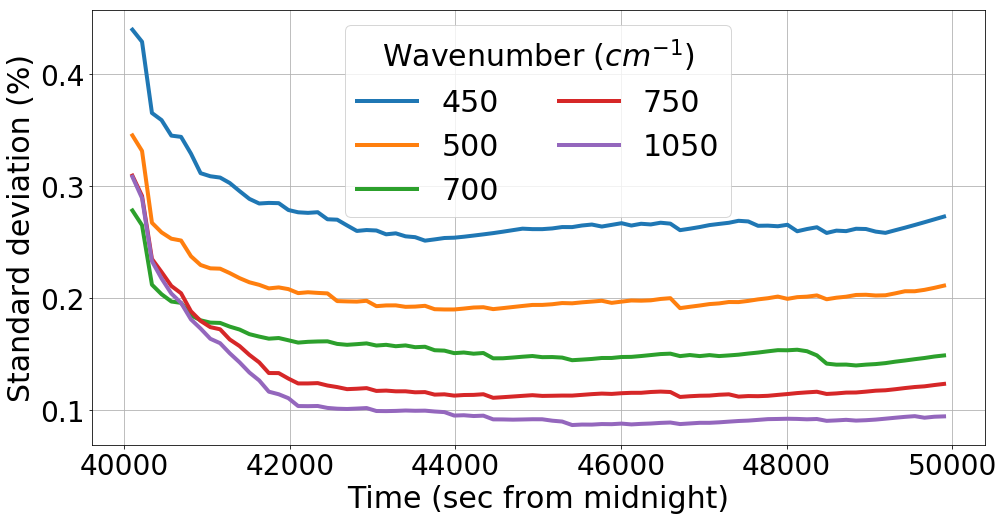

In [41]:
plot_stds_from_back(wavenums_p, all_resp_functions_p, times_p, [450, 500, 700, 750, 1050])

In [ ]:
plot_percentage_stds_from_back(flat_times_p, flat_wns_p, flat_stds_p, 'polypropylene', azimuth=10, elevation=10)

plot_percentage_stds_from_back(flat_times_zn, flat_wns_zn, flat_stds_zn, 'ZnSe', azimuth=10, elevation=10)    

In [ ]:
# Need to cut the ZnSe times to only include the stable ones